
# Resampling + GridSearchCV (Optimize F1 & ROC AUC)

This notebook adds **GridSearchCV** on top of resampling strategies to find the best model by **F1** and compare **ROC AUC**.

It evaluates:
- Baseline (no resampling)
- **SMOTE**
- **SMOTE + Tomek**
- **Class/Sample Weights**

Works for **binary** and **multiclass** targets.


In [1]:

# === EDIT THESE ===
CSV_PATH = "train_LZdllcl.csv"  # path to your CSV
TARGET_COL = 'is_promoted'                          # set e.g. "target"; if None, uses last column
ID_COLS = []                               # id-like columns to drop (optional)
RANDOM_STATE = 42

# Optional: limit features (None = use all)
KEEP_COLUMNS = None

# Cross-validation
CV_FOLDS = 5

# (Binary) while maximizing F1 via threshold tuning, keep precision >= this value
MIN_PRECISION_FOR_THRESH = 0.65


In [2]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    precision_recall_curve, roc_curve
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Preferred: XGBoost; fallback to RF
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    from sklearn.ensemble import RandomForestClassifier
    HAVE_XGB = False

# Resampling
HAVE_IMBLEARN = True
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTETomek
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
    HAVE_IMBLEARN = False
    print("imblearn not available. Install: pip install imbalanced-learn")


In [3]:

# Load CSV
df = pd.read_csv(CSV_PATH)

if KEEP_COLUMNS is not None:
    df = df[KEEP_COLUMNS]

if TARGET_COL is None:
    TARGET_COL = df.columns[-1]

for c in ID_COLS:
    if c in df.columns:
        df = df.drop(columns=[c])

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object","category"]).columns.tolist()

is_binary = y.nunique() == 2
classes_sorted = sorted(y.unique())

print("Shape:", X.shape, "| Target:", TARGET_COL)
print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))
print("Class balance:\n", y.value_counts(normalize=True).round(3))
print("Binary?", is_binary)


Shape: (54808, 13) | Target: is_promoted
Numeric: 8 | Categorical: 5
Class balance:
 is_promoted
0    0.915
1    0.085
Name: proportion, dtype: float64
Binary? True


In [4]:

# Preprocessing
numeric_tf = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_tf, num_cols),
                  ("cat", categorical_tf, cat_cols)]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (43846, 13)  Test: (10962, 13)


In [5]:

def build_model():
    if HAVE_XGB:
        return XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            random_state=42,
            eval_metric="logloss"
        )
    else:
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight=None,
            random_state=42,
            n_jobs=-1
        )

def compute_metrics(y_true, y_pred, average='binary'):
    avg = 'binary' if average=='binary' else 'macro'
    return (accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, average=avg, zero_division=0),
            recall_score(y_true, y_pred, average=avg, zero_division=0),
            f1_score(y_true, y_pred, average=avg, zero_division=0))


In [6]:

# Scoring & grids
if is_binary:
    scoring = {"f1":"f1", "roc_auc":"roc_auc"}
    refit_metric = "f1"
else:
    scoring = {"f1":"f1_macro", "roc_auc":"roc_auc_ovr_weighted"}
    refit_metric = "f1"

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)

if HAVE_XGB:
    base_param_grid = {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1, 0.2],
        "clf__max_depth": [4, 6, 8],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.7, 0.9],
        "clf__gamma": [0, 1],
        "clf__reg_lambda": [1, 5]
    }
else:
    base_param_grid = {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    }


In [7]:

from sklearn.metrics import accuracy_score  # ensure imported

def run_grid(name, pipeline, param_grid, sample_weight=None):
    print(f"\n>>> Running GridSearch for: {name}")
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit_metric,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    if sample_weight is not None:
        gs.fit(X_train, y_train, clf__sample_weight=sample_weight.values)
    else:
        gs.fit(X_train, y_train)
    print(f"Best params ({name}):", gs.best_params_)
    print(f"CV best {refit_metric.upper()} ({name}):", gs.best_score_)

    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred, average=('binary' if is_binary else 'macro'))

    # ROC AUC
    try:
        y_proba = best.predict_proba(X_test)
        if is_binary:
            auc = roc_auc_score(y_test, y_proba[:,1])
        else:
            auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")
    except Exception:
        auc = np.nan

    print(f"Test Metrics ({name}) -> Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=classes_sorted)
    ConfusionMatrixDisplay(cm, display_labels=classes_sorted).plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    return {
        "name": name,
        "grid": gs,
        "best_estimator": best,
        "test_acc": acc,
        "test_prec": prec,
        "test_rec": rec,
        "test_f1": f1,
        "test_auc": auc
    }



>>> Running GridSearch for: Baseline
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params (Baseline): {'clf__colsample_bytree': 0.7, 'clf__gamma': 1, 'clf__learning_rate': 0.2, 'clf__max_depth': 8, 'clf__n_estimators': 400, 'clf__reg_lambda': 5, 'clf__subsample': 0.8}
CV best F1 (Baseline): 0.5078891513306247
Test Metrics (Baseline) -> Acc=0.940  Prec=0.839  Rec=0.368  F1=0.512  AUC=0.904

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10028
           1       0.84      0.37      0.51       934

    accuracy                           0.94     10962
   macro avg       0.89      0.68      0.74     10962
weighted avg       0.94      0.94      0.93     10962



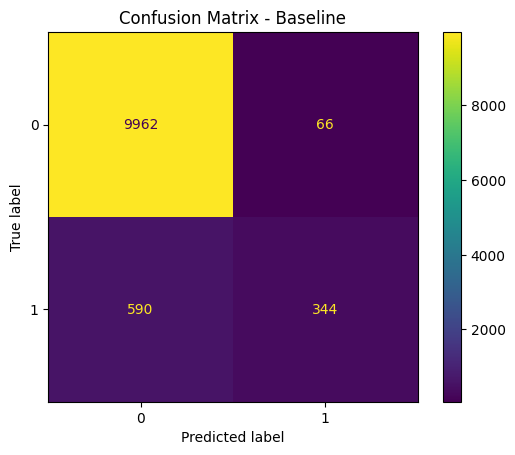


>>> Running GridSearch for: SMOTE
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params (SMOTE): {'clf__colsample_bytree': 0.9, 'clf__gamma': 1, 'clf__learning_rate': 0.2, 'clf__max_depth': 8, 'clf__n_estimators': 400, 'clf__reg_lambda': 5, 'clf__subsample': 0.8}
CV best F1 (SMOTE): 0.5100066943153416
Test Metrics (SMOTE) -> Acc=0.939  Prec=0.797  Rec=0.379  F1=0.514  AUC=0.900

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10028
           1       0.80      0.38      0.51       934

    accuracy                           0.94     10962
   macro avg       0.87      0.69      0.74     10962
weighted avg       0.93      0.94      0.93     10962



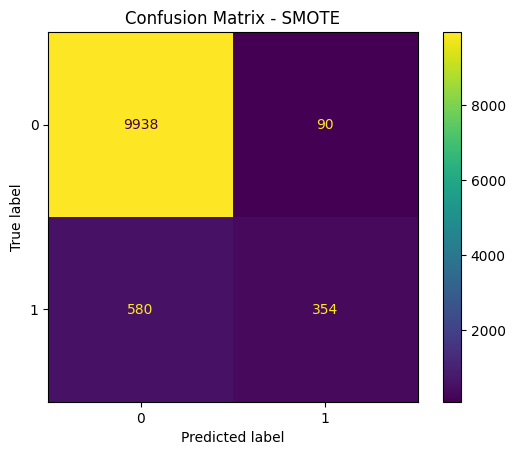


>>> Running GridSearch for: SMOTE+Tomek
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [ ]:

results = []

# Baseline
base_pipe = Pipeline(steps=[("prep", preprocessor), ("clf", build_model())])
res_base = run_grid("Baseline", base_pipe, base_param_grid)
results.append(res_base)

# SMOTE / SMOTE+Tomek
if HAVE_IMBLEARN:
    smote_pipe = ImbPipeline(steps=[("prep", preprocessor),
                                    ("smote", SMOTE(random_state=42, sampling_strategy=('auto' if is_binary else 'not majority'))),
                                    ("clf", build_model())])
    res_smote = run_grid("SMOTE", smote_pipe, base_param_grid)
    results.append(res_smote)

    smt_pipe = ImbPipeline(steps=[("prep", preprocessor),
                                  ("smt", SMOTETomek(random_state=42)),
                                  ("clf", build_model())])
    res_smt = run_grid("SMOTE+Tomek", smt_pipe, base_param_grid)
    results.append(res_smt)
else:
    print("Skipping SMOTE and SMOTE+Tomek (imblearn not installed).")


In [ ]:

# Class/Sample Weights
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_to_w = {c:w for c,w in zip(classes, cw)}
sw = y_train.map(class_to_w)

weights_pipe = Pipeline(steps=[("prep", preprocessor), ("clf", build_model())])
res_w = run_grid("Weights", weights_pipe, base_param_grid, sample_weight=sw)
results.append(res_w)


In [ ]:

# Summary
summary = pd.DataFrame([
    {"Method": r["name"], "F1": r["test_f1"], "Precision": r["test_prec"], "Recall": r["test_rec"],
     "AUC": r["test_auc"], "Accuracy": r["test_acc"], "BestParams": r["grid"].best_params_}
    for r in results
]).sort_values(by="F1", ascending=False).reset_index(drop=True)

display(summary)

summary_path = "grid_summary.csv"
summary.to_csv(summary_path, index=False)
print("Saved summary to", summary_path)

for metric in ["F1","Recall","Precision","AUC"]:
    plt.figure()
    plt.bar(summary["Method"], summary[metric])
    plt.title(f"{metric} by Method (Test)")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


In [ ]:

# (Binary only) Threshold tuning on global best model by F1
if is_binary:
    best_row = summary.iloc[0]
    best_name = best_row["Method"]
    best_model = [r for r in results if r["name"]==best_name][0]["best_estimator"]

    y_proba = best_model.predict_proba(X_test)[:,1]
    thresholds = np.linspace(0.1, 0.9, 41)
    best = (-1, 0.5, 0, 0)
    for t in thresholds:
        y_hat = (y_proba >= t).astype(int)
        p = precision_score(y_test, y_hat, zero_division=0)
        r = recall_score(y_test, y_hat, zero_division=0)
        f1 = f1_score(y_test, y_hat, zero_division=0)
        if p >= MIN_PRECISION_FOR_THRESH and f1 > best[0]:
            best = (f1, t, p, r)

    best_f1, best_t, best_p, best_r = best
    if best_f1 > 0:
        print(f"Best threshold on {best_name}: t={best_t:.2f} | Prec={best_p:.3f} Rec={best_r:.3f} F1={best_f1:.3f}")
        prec, reca, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(reca, prec); plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"PR Curve - {best_name}"); plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(); plt.plot(fpr, tpr)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC Curve - {best_name}")
        plt.show()
    else:
        print(f"No threshold met precision >= {MIN_PRECISION_FOR_THRESH}.")
else:
    print("Threshold tuning skipped for multiclass.")
